<a href="https://colab.research.google.com/github/choki0715/UnLiteFlowNet-PIV/blob/master/TS_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""""
file : transformer_time_series_tf.ipynb

author : euijoong kim

copy right to aidentify Inc.

"""

#import tensorflow_datasets as tfds
import tensorflow as tf
import time
import os, sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import csv

from google.colab import drive 
drive.mount('/content/gdrive/')
file_path = '/gdrive/MyDrive/sample_train_data' 
#os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, file_path)


Mounted at /content/gdrive/


In [ ]:
!ls  gdrive/MyDrive/sample_train_data

01_data_ready.ipynb  feature_n13_2013_2017.csv	   test_02_itp_day_n14.csv
02_data_ready.ipynb  feature_n13_20181_20187.csv   test_03_itp_day_n14.csv
03_data_ready.ipynb  feature_n13_20189_2022.csv    train_01_itp_day_n14.csv
df_12H_mean.csv      itp_day_n14_20131_201702.csv  train_02_itp_day_n14.csv
df_24H_mean.csv      prepare_01.ipynb		   train_03_itp_day_n14.csv
df_6H_mean.csv	     test_01_itp_day_n14.csv


In [ ]:
# 데이터 불러오기
df1 = pd.read_csv('./gdrive/MyDrive/sample_train_data/train_01_itp_day_n14.csv')
df2 = pd.read_csv('./gdrive/MyDrive/sample_train_data/train_02_itp_day_n14.csv')
df3 = pd.read_csv('./gdrive/MyDrive/sample_train_data/train_03_itp_day_n14.csv')


In [ ]:
# 데이터 확인

# 시간항목 삭제
df1=df1.drop(['datetime'], axis=1)
df2=df2.drop(['datetime'], axis=1)
df3=df3.drop(['datetime'], axis=1)

# data bolck #1
print(df1.shape)
print(df2.shape)
print(df3.shape)


(549, 14)
(462, 14)
(446, 14)


In [ ]:
# global parameter setup
# 하이퍼파라메터 정의

gamma = 0.00001 # small number to prevent NaN
d_model = 128 # input embedding vector size
past_step = 18 # input data seq length
next_step = 7 # output data seq length

# hyperparameters for transformer
num_layers = 4 # cell module stack size
dff = 256 # hidden vector size
num_heads = 8 # multi head attention's number of heads
dropout_rate = 0.3 # dropout rate

BUFFER_SIZE = 300 # buffer size fo shuffling
MAX_LENGTH = 28 # maximum sequence length
MAX_FEATURE = 256 # maximum feature size (= vocab_size in NLP)

BATCH_SIZE = 20 # 배치사이즈

FINAL = False # when freezing version --> True
STRIDE = 1 # 데이터 생성시 stride 거리

FINAL

df1.head()

,temperature,turbidity,pH,algae,alkali,TOC,elec-conduct,res-chlorine,green-algae,blue-algae,diatom,chevron-algae,MIB,Geosmin
0,1.33150,4.11230,7.46560,9.50570,46.15330,1.91830,205.60800,0.0021,0.0,3.7338,5.7727,0.0,0.000000,5.500000
1,0.76890,2.78760,7.52080,2.06850,37.04620,0.90090,108.65910,0.0000,0.0,0.8692,1.1992,0.0,3.085695,1.894550
2,0.76410,2.87310,7.56770,1.99070,42.81680,1.11130,111.79190,0.0000,0.0,0.8267,1.1640,0.0,2.981390,1.969101
3,0.83150,2.88100,7.60220,2.00250,43.31300,1.10140,118.43340,0.0000,0.0,0.8265,1.1782,0.0,2.877084,2.043651
4,0.81758,2.87268,7.59778,2.01604,43.35156,1.07842,118.70464,0.0000,0.0,0.0000,0.0000,0.0,2.772779,2.118202


In [ ]:

# 학습데이터 정규화

dataset_1 = np.array(df1.values, dtype=np.float32)
dataset_2 = np.array(df2.values, dtype=np.float32)
dataset_3 = np.array(df3.values, dtype=np.float32)

# data block #1
mean_1 = dataset_1.mean(axis=0)
std_1 = dataset_1.std(axis=0)
data_norm_1 = (dataset_1 - mean_1)/(std_1 + gamma)

# data block #2
mean_2 = dataset_2.mean(axis=0)
std_2 = dataset_2.std(axis=0)
data_norm_2 = (dataset_2 - mean_2)/(std_2 + gamma)

# data block #3
mean_3 = dataset_3.mean(axis=0)
std_3 = dataset_3.std(axis=0)
data_norm_3 = (dataset_3 - mean_3)/(std_3 + gamma)

# data block's # of raw, # of column
data_raw_col =np.zeros((3,2))

# data block 
data_raw_col[0] = data_norm_1.shape
data_raw_col[1] = data_norm_2.shape
data_raw_col[2] = data_norm_3.shape

data_raw_col = np.int_(data_raw_col)
# input vec dim, output vector dim
inp_dim = data_raw_col[0,1]   # input # of features = 14
out_dim = data_raw_col[0,1]   # output # of features = 14
num_data_blocks, _  = data_raw_col.shape
print(data_raw_col)
print(inp_dim, out_dim)
print(num_data_blocks)

[[549  14]
 [462  14]
 [446  14]]
14 14
3


In [ ]:
# merge all dataset to one

dataset = np.append(data_norm_1, data_norm_2, axis=0)
dataset = np.append(dataset, data_norm_3, axis=0)

dataset.shape

(1457, 14)

In [ ]:
# 학습데이터 --> 입력데이터, 레이블 작성 
def dataset_build(dataset, target, past_size, next_size, num_data_blocks,
                  raw_col, stride, final):

    gamma = 0.00001
    inp_dim = raw_col[0,1]
    out_dim = raw_col[0,1]

    train_x = []
    train_y = []
    val_x = []
    val_y = []

    dum_data = np.zeros([past_size, inp_dim], dtype=np.float32)
    dum_label = np.zeros([next_size, out_dim], dtype=np.float32)
    
    
    for itr in range(num_data_blocks):
       # define split point for validation data 
       train_split = np.int_(raw_col[itr,0] * 0.8)

       # making single data for train
       if itr == 0:
          init_idx_train = 0
       else:
          init_idx_train = init_idx_train + raw_col[itr-1,0]

       end_idx_train = init_idx_train + train_split

       for i in range(init_idx_train, end_idx_train, stride):

          # train_x
          indices = range(i, i + past_size)
          dum_data = dataset[indices]
          train_x.append(dum_data)
          # train_y
          indices = range(i+past_size, i+past_size+next_size)
          dum_label=target[indices]
          train_y.append(dum_label)

       # making single data for validation
       if itr == 0:
          init_idx_val = train_split
       else:
          init_idx_val = train_split + raw_col[itr-1,0]

       end_idx_val = raw_col[itr,0]

       for i in range(init_idx_val, end_idx_val, stride):
          # val_x
          indices = range(i - past_size, i)
          dum_data = dataset[indices]
          val_x.append(dum_data)
          # val_y
          indices = range(i-1, i+next_size-1)
          dum_label=target[indices]
          val_y.append(dum_label)

    return np.array(train_x, dtype=np.float32), np.array(train_y, dtype=np.float32), np.array(val_x, dtype=np.float32), np.array(val_y, dtype=np.float32)


In [ ]:
print('FINAL = ', FINAL)

if FINAL == True:
    print('execuation stage : FINAL = true')

    x_train, y_train = dataset_build(dataset, dataset, past_step, next_step, num_data_blocks, data_raw_col, STRIDE, FINAL)
    indices = range(len(dataset)-past_step, len(dataset))
    last_x  = np.array(dataset[indices], dtype=np.float32)
    last_y  = dataset[len(dataset)-1,-1]
    
else:
 
    x_train, y_train, x_val, y_val = dataset_build(dataset, dataset, past_step, next_step, num_data_blocks, data_raw_col, STRIDE, FINAL)

    print(x_train.shape, y_train.shape)

# total number of train and validation data
num_train, _, _ = x_train.shape
num_val, _, _ = x_val.shape 

print (' train data size : {}, train total counts {}'.format(x_train[0].shape, x_train.shape))
print (' train label size : {}, train label counts {}'.format(y_train[0].shape, y_train.shape))
print (' train x size : {}, val x size {}'.format(num_train, num_val))

if FINAL == True:
    print(' last_x size = ', last_x.shape)
    print(' last_y size = ', last_y.shape, last_y)

else:
    print (' validation data size : {}, val data total counts {}'.format(x_val[0].shape, x_val.shape))
    print (' validation label size : {}, val label total counts {}'.format(y_val[0].shape, y_val.shape))
    len(x_val)

FINAL =  False
(1164, 18, 14) (1164, 7, 14)
 train data size : (18, 14), train total counts (1164, 18, 14)
 train label size : (7, 14), train label counts (1164, 7, 14)
 train x size : 1164, val x size 110
 validation data size : (18, 14), val data total counts (110, 18, 14)
 validation label size : (7, 14), val label total counts (110, 7, 14)


In [ ]:
# train data set, validation data set preparation

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

if FINAL == False:
    val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    #val_data = val_data.cache().shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).repeat()
    #val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:

# plot results
def result_plot(past, label, pred, opt, num):
    # 시간축 x 값 생성 
    plt.figure(figsize=(12, 6))
    past_timesteps = list(range(-len(past),0))
    next_timesteps = list(range(0, len(label)))
    # feature to look at
    ftr = 3
    plt.plot(past_timesteps, np.array(past[:, ftr]), label='Past')
    plt.plot(next_timesteps, np.array(label[:, ftr]), 'b-',
           label='True Future')
    if opt == True:
        plt.plot(next_timesteps, np.array(pred[:, ftr]), 'r-',
             label='Pred Future')
    plt.legend(loc='upper left')
    plt.show()

(7, 14)


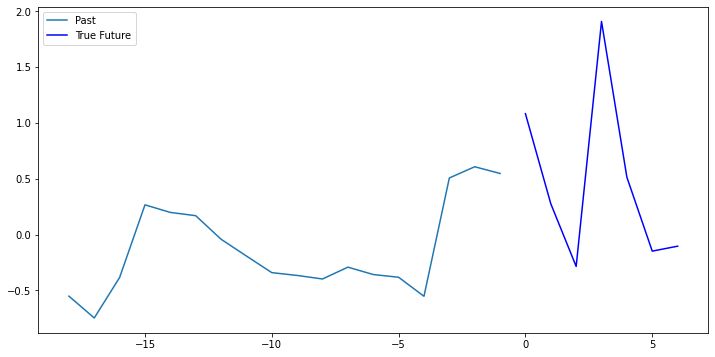

(7, 14)


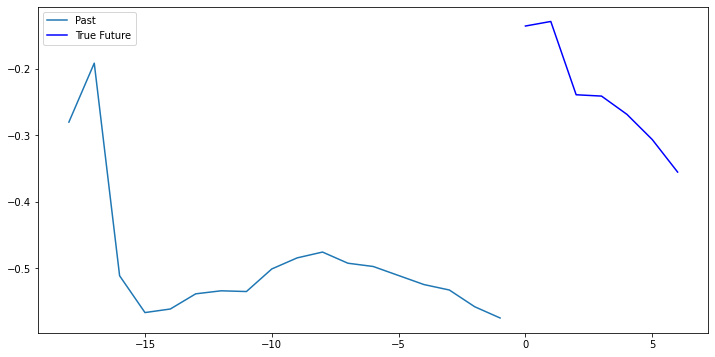

(7, 14)


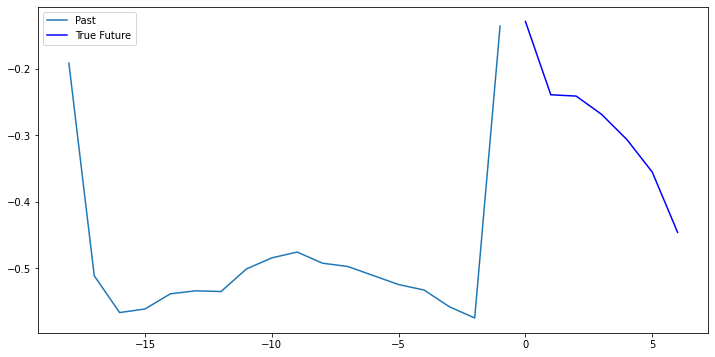

(7, 14)


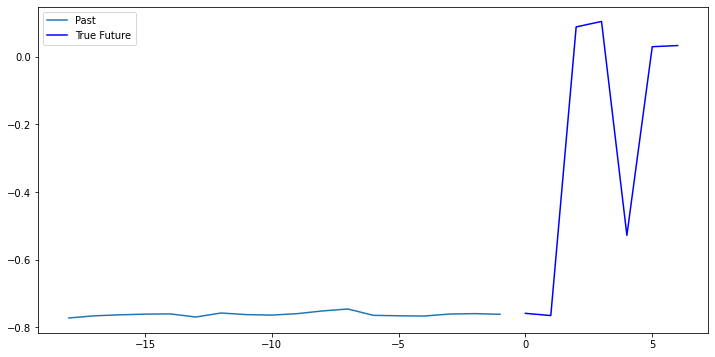

(7, 14)


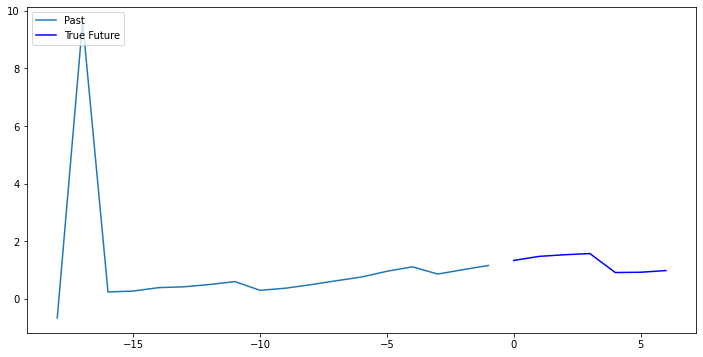

In [ ]:
for x, y in train_data.take(5):
    print(y[0].shape)
    result_plot(x[0], y[0], y[0], False, 1)

(1, 18, 160)


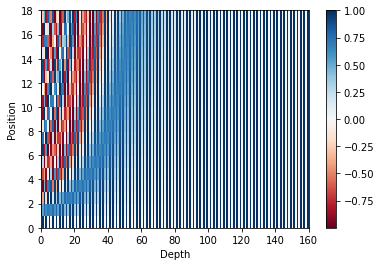

In [ ]:
# positional encoding

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

# f_len: feature vector size
f_len = 160
pos_encoding = positional_encoding(18, f_len)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 160))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
"""## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. 
The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

"""

# 입력값 및 예측값의 차원이 일정하면 마스킹은 필요없음
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

# check if padding works
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
#x = tf.random.uniform((64, 72, 8))
temp = create_padding_mask(x)
print(temp)

"""The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.
"""

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0) # -1 (lower part keep all) 0 (upper part keep none)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((64, 72, 8))
temp = create_look_ahead_mask(x.shape[1])
temp

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


<tf.Tensor: shape=(72, 72), dtype=float32, numpy=
array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
"""## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.
"""

def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
  
    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
      output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

"""As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.
"""

def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

"""Pass all the queries together."""

temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

"""## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.
"""

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
    
        self.depth = d_model // self.num_heads
    
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
    
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
    
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
    
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

    """Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, 
       the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, 
       returning a new vector of the same length at each location.
    """

temp_mha = MultiHeadAttention(d_model=256, num_heads=8)
y = tf.random.uniform((64, 24, 160))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

"""## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.
"""

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
     ])

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 160))).shape

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


TensorShape([64, 50, 512])

In [ ]:
"""## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word.

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.
"""

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2

# check if definition is correct
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [ ]:
"""### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.
"""

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)
 
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, 
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        # (batch_size, target_seq_len, d_model) v, k, q
        
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
    
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
        return out3, attn_weights_block1, attn_weights_block2

# check if definition is correct
sample_decoder_layer = DecoderLayer(8, 8, 512)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((1, 1, 1)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([1, 1, 8])

In [ ]:
"""### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.
"""
# num_layers, d_model, num_heads, dff, pe_input, pe_target, num_ftr, rate=0.1

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 past_seq, num_ftr, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.num_ftr = num_ftr
        self.past_seq = past_seq
        
        self.embedding = tf.keras.layers.Dense(d_model)
         
        # self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(self.past_seq, self.d_model)
    
    
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
  
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        batch_size = tf.shape(x)[0]   

        # adding embedding and position encoding.
        if training == True:
            # 39 is number of input dim --> need to be modified
            x = tf.reshape(x, (batch_size, self.past_seq, self.num_ftr))
        
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    
        # adding embedding and position encoding.
        # x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x  # (batch_size, input_seq_len, d_model)

# check if definition is correct
#sample_encoder = Encoder(num_layers=4, d_model=256, num_heads=8, 
#                         dff=2048, #input_vocab_size=8500,
#                         maximum_position_encoding=10000)
#temp_input = tf.random.uniform((64, 72, 8), dtype=tf.float32, minval=0, maxval=200)
#
#sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)
#
#print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

In [ ]:
"""### Decoder

The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.
"""

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 next_seq, num_ftr, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.next_seq = next_seq
        self.num_ftr = num_ftr
        
        self.embedding = tf.keras.layers.Dense(d_model)
    
        # self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(self.next_seq, d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
             look_ahead_mask, padding_mask):

        batch_size = tf.shape(x)[0]

        attention_weights = {}
 
        # adding embedding and position encoding.
        if training == True:
            x = tf.reshape(x, (batch_size, self.next_seq, self.num_ftr))
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
       
        attention_weights = {}
    
        # x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding
    
        print('in decoder seq_len === ', self.next_seq)
        
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                  look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        #x = self.dense(x)
        
        return x, attention_weights

# check if definition is correct
#sample_decoder = Decoder(num_layers=4, d_model=256, num_heads=8, dff=512, 
#                         maximum_position_encoding=5000)
#temp_input = tf.random.uniform((64,16,1), dtype=tf.float32, minval=0, maxval=200)
#
#output, attn = sample_decoder(temp_input, 
#                              enc_output=sample_encoder_output, 
#                              training=False,
#                              look_ahead_mask=None, 
#                              padding_mask=None)
#
#output.shape, attn['decoder_layer2_block2'].shape

In [ ]:
"""## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.
"""

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, past_seq, next_seq, num_ftr, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               past_seq, num_ftr, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               next_seq, num_ftr, rate)

        self.final_layer = tf.keras.layers.Dense(num_ftr) 
    
    def call(self, inp, tar, training, enc_padding_mask, 
             look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, d_model)
    
        return final_output, attention_weights

# d_model = length of feature vector
sample_transformer = Transformer(
    num_layers=4, d_model=256, num_heads=8, dff=512,
    # input_vocab_size=8500, target_vocab_size=8000, 
    past_seq=24, next_seq=12, num_ftr=14)

# input: (batch_size, inp_seq_len, d_model)
temp_input = tf.random.uniform((20, 24, 170), dtype=tf.float32, minval=0, maxval=200)
temp_target = tf.random.uniform((20, 12, 1), dtype=tf.float32, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

in decoder seq_len ===  12


TensorShape([20, 12, 14])

Text(0.5, 0, 'Train Step')

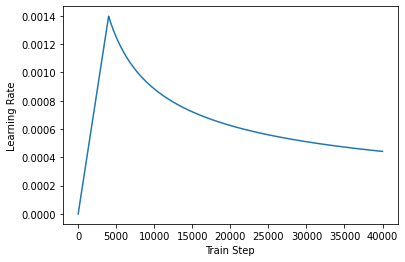

In [ ]:
"""## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.
"""


"""## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$
"""

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
"""## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.
"""

# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
#    from_logits=True, reduction='none')
loss_object = tf.keras.losses.MeanSquaredError(reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))

    # true1, true2 = tf.split(real, [1, d_model-1], axis=2)
    loss_ = loss_object(real, pred)

    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
  
    return tf.reduce_sum(loss_) #/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.MeanSquaredError(name='train_accuracy')

"""## Training and checkpointing"""

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          past_step, next_step, out_dim,
                          rate=dropout_rate)

def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    dec_padding_mask = create_padding_mask(inp)

    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    #print('look head mask ', look_ahead_mask.shape, look_ahead_mask) 
        
    dec_target_padding_mask = create_padding_mask(tar)
    #print('dec target mask ', dec_target_padding_mask.shape, dec_target_padding_mask) 
        
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

temp_input = tf.random.uniform((1, 24, 160), dtype=tf.float32, minval=0, maxval=200)
temp_target = tf.random.uniform((1, 6, 1), dtype=tf.float32, minval=0, maxval=200)
print('before = ', temp_input)
temp_input = temp_input[:,:,0]
print('after = ', temp_input)
temp_target = temp_target[:,:,0]
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(temp_input, temp_target)

before =  tf.Tensor(
[[[150.6179     69.994545  110.6389    ...  90.33635   157.48294
   197.6571   ]
  [ 20.61007    12.773585  140.83672   ... 136.78232    49.693607
   177.1998   ]
  [ 55.52392    56.315613  143.04948   ... 179.27373   164.9907
   198.17273  ]
  ...
  [ 84.736275   45.707558  177.16052   ... 182.70772     5.661297
    75.396706 ]
  [110.44004    60.017944  136.60168   ...  26.180672  102.57895
   144.06586  ]
  [ 23.962831  163.24521   132.43672   ...  18.675041    1.7725706
    72.07072  ]]], shape=(1, 24, 160), dtype=float32)
after =  tf.Tensor(
[[150.6179     20.61007    55.52392    35.623978  121.48068   163.53676
    6.132579  194.85893    58.94785   136.79135    91.65752     7.6558113
  194.79341   117.55698    90.91473   190.71593    56.91793    27.420855
   10.361528  155.34273   195.43546    84.736275  110.44004    23.962831 ]], shape=(1, 24), dtype=float32)


In [ ]:
"""Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs."""

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


EPOCHS = 100

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
]

@tf.function(input_signature=train_step_signature)

def train_step(inp, tar):

    tar_inp = tar[:, 0 :-1,:]
    tar_real = tar[:,1 : ,:]
  
    #print('tar_inp  ==== ', tar_inp, tar_inp.shape)
    #print('tar_real ==== ', tar_real, tar_real.shape)
    
    inp_mod = inp[:,:,0]
    tar_inp_mod = tar_inp[:,:,0]
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp_mod, tar_inp_mod)
    
    #print('enc_padding_mask = ', enc_padding_mask.shape)
    #print('combined_mask    = ', combined_mask.shape)
    #print('dec_padding_mask = ', dec_padding_mask.shape)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar, 
                                     True, 
                                     enc_padding_mask=None, 
                                     look_ahead_mask=None, 
                                     dec_padding_mask=None)
        
        print('prediction ====', predictions, predictions.shape[1])
        print('target     ====', tar, tar.shape)
        
        loss = loss_function(tar, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar, predictions)

start = time.time()
  
train_loss.reset_states()
train_accuracy.reset_states()

one_epoch_size = num_train//(STRIDE*BATCH_SIZE) 
#one_epoch_size = 500

# inp -> past 24 time steps, tar -> future 6 time steps
new_epoch = 1
for (batch, (x, y)) in enumerate(train_data):
    
    epoch = batch // one_epoch_size
    
   #  y = tf.expand_dims(y, axis=2)
    
    # print('y label ===== ', y, y.shape)
    
    train_step(x, y)
    
    if batch % 50 == 0:
         print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
             epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if epoch == new_epoch:
        new_epoch += 1
        if (epoch + 1) % 3 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
      
        print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                    train_loss.result(), 
                                                    train_accuracy.result()))

        print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

    if epoch == EPOCHS:
        break

    

Latest checkpoint restored!!
in decoder seq_len ===  7
prediction ==== Tensor("transformer_9/dense_651/BiasAdd:0", shape=(None, 7, 14), dtype=float32) 7
target     ==== Tensor("tar:0", shape=(None, None, None), dtype=float32) (None, None, None)
Epoch 1 Batch 0 Loss 3.1217 Accuracy 0.0223
Epoch 1 Batch 50 Loss 4.4835 Accuracy 0.0320
Epoch 2 Loss 4.3574 Accuracy 0.0316
Time taken for 1 epoch: 16.346124172210693 secs

Epoch 2 Batch 100 Loss 4.4757 Accuracy 0.0322
Saving checkpoint for epoch 3 at ./checkpoints/train/ckpt-34
Epoch 3 Loss 4.4507 Accuracy 0.0320
Time taken for 1 epoch: 22.902232885360718 secs

Epoch 3 Batch 150 Loss 4.5184 Accuracy 0.0326
Epoch 4 Loss 4.7010 Accuracy 0.0339
Time taken for 1 epoch: 29.285338163375854 secs

Epoch 4 Batch 200 Loss 4.7499 Accuracy 0.0343
Epoch 5 Loss 4.7577 Accuracy 0.0343
Time taken for 1 epoch: 35.576587438583374 secs

Epoch 5 Batch 250 Loss 4.7656 Accuracy 0.0345
Saving checkpoint for epoch 6 at ./checkpoints/train/ckpt-35
Epoch 6 Loss 4.7180 

In [ ]:
"""## Evaluate"""

def evaluate(input, init_value, tar_seq):
    
    # set dimension as to train format
    encoder_input = tf.expand_dims(input, 0)
    #encoder_input = input
        
    # initial vaue for decoder
    print('init value shape === ', init_value.shape)
    decoder_input = init_value[0]
    print('decoder_input shape === ', decoder_input.shape)
    decoder_input = tf.expand_dims(decoder_input, 0)
    decoder_input = tf.expand_dims(decoder_input, 0)
    
    for i in range(tar_seq):
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     decoder_input,
                                                     False,
                                                     enc_padding_mask=None,
                                                     look_ahead_mask=None,
                                                     dec_padding_mask=None)
    
        # select the last word from the seq_len dimension
        #predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        print('prediction === ', predictions.shape, i)
        next_y = tf.expand_dims(predictions, 0)
        # next_y = tf.expand_dims(next_y, 0)

        decoder_input = tf.concat([decoder_input, next_y], axis=1)

    return tf.squeeze(decoder_input, axis=0), attention_weights

def plot_attention_weights(attention, sentence, result, layer, num):
    fig = plt.figure(figsize=(16, 6))
  
   # sentence = tokenizer_pt.encode(sentence)
  
    attention = tf.squeeze(attention[layer], axis=0)
    overlap_attention = np.zeros((attention.shape[1], attention.shape[2]))

    for head in range(attention.shape[0]):
        overlap_attention += attention[head]  

    all_view = fig.add_subplot(111)
    all_view.set_xlabel('Time Frame {}'.format(num))
    all_view.set_xticks(range(0, len(sentence), 2))
    all_view.set_yticks(range(0, len(result), 2))
    all_view.set_ylim(len(result)-0.1, 0)
    all_view.matshow(overlap_attention, cmap='YlGn')
    plt.tight_layout()
    # plt.colorbar()
    plt.show()
    plt.savefig('./attention_view{}.png'.format(num), bbox_inches='tight')


# 시간축 x 값 생성 

def result_plot(past, next_true, next_pred, opt, num):
    plt.figure(figsize=(12, 6))
    past_timestpes = list(range(-len(past),0))
    next_timesteps = list(range(0,len(true_future)))

    plt.plot(num_in, np.array(past[:, 35]), label='Past')
    plt.plot(np.arange(num_out-1), np.array(true_future[1:]), 'b-',
             label='True')
    if opt == True:
        plt.plot(np.arange(num_out-1), np.array(pred_future[1:,0]), 'r-',
                 label='Pred')
    plt.legend(loc='upper left')
    plt.show()
    plt.savefig('./prediction{}.png'.format(num), bbox_inches='tight', pad_inches=0.0, dpi=200,)

In [ ]:
plot_bound = 20
plot_cnt = 0
cnt = 0

csvfile = open('./result.csv', 'w')
csvwrite = csv.writer(csvfile)

if FINAL == True:
    x = last_x
    #print('last x ',x, x.shape)
    y = tf.cast([np.random.randn(1)]*next_step,dtype=np.float32)
    #y = tf.expand_dims(y, 1)
    #print('y111============', y, y.shape)
    
    #y = tf.expand_dims(y_train[82], 1)
    #print('y222============', y, y.shape)
        
    prediction, attention_weights = evaluate(x, y, next_step-1)    
    #prediction, attention_weights = transformer(x, y, 
    #                                    training=False, 
    #                                    enc_padding_mask=None, 
    #                                    look_ahead_mask=None, 
    #                                    dec_padding_mask=None)

    # pred = np.array(tf.squeeze(prediction))
    result_plot(x, y, pred, cnt)
    #attention_weights
    plot_attention_weights(attention_weights, x, pred, 'decoder_layer4_block2', cnt)
        
    csvwrite.writerow('# {}'.format(cnt))
    csvwrite.writerow(tf.make_ndarray(tf.make_tensor_proto(x[:,159])))
    csvwrite.writerow(tf.make_ndarray(tf.make_tensor_proto(y)))
    csvwrite.writerow(tf.make_ndarray(tf.make_tensor_proto(pred)))

else:
    ftr = 10
    for i in range(len(x_val)):
        print('iteration = ', i)
        x = x_val[i]
        y = y_val[i]
        #print('x_val shape', x_val.shape, x_val[i])
        #print('x ++++++++++===== ', x, x.shape)
        #print('y ===== ', y, y[0])
        
        prediction, attention_weights = evaluate(x, y, next_step)    

        #print('y prediction  ===== ', prediction)

        #y = tf.expand_dims(y, axis=1)
        
        #prediction, attention_weights = transformer(x, y, 
        #                                False, 
        #                                enc_padding_mask=None, 
        #                                look_ahead_mask=None, 
        #                                dec_padding_mask=None)
  
        # pred = np.array(tf.squeeze(prediction))
        result_plot(x, y, prediction, True, cnt, ftr)

        # attention_weights
        plot_attention_weights(attention_weights, x, prediction, 'decoder_layer4_block2', cnt)
        
        csvwrite.writerow('# {}'.format(cnt))
        csvwrite.writerow(tf.make_ndarray(tf.make_tensor_proto(x[:,35])))
        csvwrite.writerow(tf.make_ndarray(tf.make_tensor_proto(y)))
        csvwrite.writerow(tf.make_ndarray(tf.make_tensor_proto(prediction)))
        
        cnt +=1
        plot_cnt += 1
    

iteration =  0
init value shape ===  (7, 14)
decoder_input shape ===  (14,)
in decoder seq_len ===  7
prediction ===  (1, 7, 14) 0


InvalidArgumentError: ignored